### U-NET

In [1]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models
from tensorflow.keras.layers import *

In [36]:
os.getcwd()

'/mnt/processed/private/msds2025/cpt2/ML 3/Final Project'

### View File Names
Uncomment below to see list of files

In [3]:
# masks_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/generated-damage-masks'
# damaged_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/generated-damaged-images'
# img_train = 'art-restoration-ai/data/damaged-and-mask-dataset/img/test'

# mask_files = [f for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))]
# damaged_files = [f for f in os.listdir(damaged_dir) if os.path.isfile(os.path.join(damaged_dir, f))]

# print(f'   Masks \n{mask_files[:5]}')
# print(f'   Damaged \n{damaged_files[:5]}')

### Train-Test Split
Uncomment below if train and test images have not yet been copied according to their respective directories

In [4]:
# damaged_img_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/generated-damaged-images'
# damage_mask_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/generated-damage-masks'

# train_img_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/img/train'
# test_img_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/img/test'
# train_mask_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/mask/train'
# test_mask_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/mask/test'

# os.makedirs(train_img_dir, exist_ok=True)
# os.makedirs(test_img_dir, exist_ok=True)
# os.makedirs(train_mask_dir, exist_ok=True)
# os.makedirs(test_mask_dir, exist_ok=True)

# # --- Shuffle files in damaged_img_dir ---
# all_images = [f for f in os.listdir(damaged_img_dir) if f.lower().endswith('.png')]
# random.seed(42)
# random.shuffle(all_images)

# # --- Train-test split ---
# split_index = int(0.75 * len(all_images))
# train_images = all_images[:split_index]
# test_images = all_images[split_index:]

# # --- Copy files ---
# def copy_files(img_list, target_img_dir, target_mask_dir):
#     for fname in img_list:
#         src_img_path = os.path.join(damaged_img_dir, fname)
#         dst_img_path = os.path.join(target_img_dir, fname)
#         shutil.copy(src_img_path, dst_img_path)

#         base_name = fname.replace('.png', '')
#         mask_name = f'{base_name}-mask.png'
#         src_mask_path = os.path.join(damage_mask_dir, mask_name)
#         dst_mask_path = os.path.join(target_mask_dir, mask_name)
#         if os.path.exists(src_mask_path):
#             shutil.copy(src_mask_path, dst_mask_path)
#         else:
#             print(f'Warning: file name {fname} not found')

# # --- Implement copy_files function ---
# copy_files(train_images, train_img_dir, train_mask_dir)
# copy_files(test_images, test_img_dir, test_mask_dir)

# print(f"Split complete: {len(train_images)} train, {len(test_images)} test")

In [5]:
# img_train_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/img/test'
# mask_train_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/mask/test'

# mask_train = [f for f in os.listdir(mask_train_dir) if os.path.isfile(os.path.join(mask_train_dir, f))]
# damaged_train = [f for f in os.listdir(img_train_dir) if os.path.isfile(os.path.join(img_train_dir, f))]

# print(f'   Mask Train Images \n{mask_train[:5]}')
# print(f'   Damaged Train Images \n{damaged_train[:5]}')

### CAREFUL SPONGEBOB CAREFUL SPONGEBOB CAREFUL SPONGEBOB CARE-FUL-SPONGE-BOB!
Only run the code below if need to delete a populated directory

In [6]:
# !rm -rf 'art-restoration-ai/data/damaged-and-mask-dataset/img'

### Data Generator
Convert images to tensors

In [7]:
class DamageDataGenerator(Sequence):
    def __init__(self, image_filenames, image_dir, mask_dir, batch_size=8, image_size=(256, 256)):
        self.image_filenames = image_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        masks = []

        for fname in batch_files:
            img_path = os.path.join(self.image_dir, fname)
            mask_name = fname.replace(".png", "-mask.png")
            mask_path = os.path.join(self.mask_dir, mask_name)

            img = load_img(img_path, target_size=self.image_size)
            img = img_to_array(img) / 255.0
            images.append(img)

            mask = load_img(mask_path, target_size=self.image_size, color_mode="grayscale")
            mask = img_to_array(mask) / 255.0
            masks.append(mask)

        return np.array(images), np.array(masks)

### U-NET Model Architecture

In [17]:
# --- UNet Model ---
def down_block(x, filters, use_maxpool=True):
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    if use_maxpool:
        return MaxPooling2D((2, 2))(x), x
    else:
        return x

def up_block(x, skip, filters):
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip])
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

def build_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    x, skip1 = down_block(inputs, 64)
    x, skip2 = down_block(x, 128)
    x, skip3 = down_block(x, 256)
    x, skip4 = down_block(x, 512)
    x = down_block(x, 1024, use_maxpool=False)
    x = up_block(x, skip4, 512)
    x = up_block(x, skip3, 256)
    x = up_block(x, skip2, 128)
    x = up_block(x, skip1, 64)
    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)


### Metrics Functions

In [18]:
# --- Metrics ---
def iou_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_coef(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

def precision(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return tp / (tp + fp + 1e-7)

def recall(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return tp / (tp + fn + 1e-7)

### U-NET Training

In [19]:
train_img_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/img/train'
test_img_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/img/test'
train_mask_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/mask/train'
test_mask_dir = 'art-restoration-ai/data/damaged-and-mask-dataset/mask/test'

train_images = sorted([f for f in os.listdir(train_img_dir) if f.lower().endswith('.png')])
test_images = sorted([f for f in os.listdir(test_img_dir) if f.lower().endswith('.png')])

In [20]:
# --- Prepare Data Generators ---
train_generator = DamageDataGenerator(train_images, train_img_dir, train_mask_dir)
test_generator = DamageDataGenerator(test_images, test_img_dir, test_mask_dir)

# --- Callbacks ---
checkpoint_cb = ModelCheckpoint("best_unet_model.h5", 
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min')
earlystopping_cb = EarlyStopping(monitor='val_loss', patience=5,
                                 restore_best_weights=True)

# --- Compile and Train Model ---
model = build_unet()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric,
                       dice_coef, precision, recall])
model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[checkpoint_cb, earlystopping_cb],
    workers=4,
    use_multiprocessing=True)

# --- Save Model ---
model.save("unet_damage_mappingv2.h5")

Epoch 1/20
3242/3242 [==============================] - 811s 249ms/step - loss: 0.1494 - accuracy: 0.9470 - iou_metric: 0.4587 - dice_coef: 0.6064 - precision: 0.8005 - recall: 0.5194 - val_loss: 0.0969 - val_accuracy: 0.9648 - val_iou_metric: 0.6229 - val_dice_coef: 0.7595 - val_precision: 0.9078 - val_recall: 0.6639
Epoch 2/20
3242/3242 [==============================] - 807s 249ms/step - loss: 0.0763 - accuracy: 0.9729 - iou_metric: 0.7164 - dice_coef: 0.8303 - precision: 0.8944 - recall: 0.7844 - val_loss: 0.0604 - val_accuracy: 0.9778 - val_iou_metric: 0.7688 - val_dice_coef: 0.8667 - val_precision: 0.8990 - val_recall: 0.8408
Epoch 3/20
1412/3242 [============>.................] - ETA: 6:45 - loss: 0.0548 - accuracy: 0.9808 - iou_metric: 0.7917 - dice_coef: 0.8815 - precision: 0.9223 - recall: 0.8491 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3242/3242 [==============================] - 810s 250ms/step - loss: 0.0511 - accuracy: 0.9821 - iou_metric: 0.8070 - dice_coef: 0.8912 - precision: 0.9275 - recall: 0.8618 - val_loss: 0.0509 - val_accuracy: 0.9830 - val_iou_metric: 0.8133 - val_dice_coef: 0.8946 - val_precision: 0.9531 - val_recall: 0.8468
Epoch 4/20
3242/3242 [==============================] - 810s 250ms/step - loss: 0.0402 - accuracy: 0.9859 - iou_metric: 0.8456 - dice_coef: 0.9151 - precision: 0.9418 - recall: 0.8925 - val_loss: 0.0386 - val_accuracy: 0.9863 - val_iou_metric: 0.8513 - val_dice_coef: 0.9185 - val_precision: 0.9441 - val_recall: 0.8966
Epoch 5/20
3242/3242 [==============================] - 811s 250ms/step - loss: 0.0347 - accuracy: 0.9878 - iou_metric: 0.8649 - dice_coef: 0.9265 - precision: 0.9490 - recall: 0.9071 - val_loss: 0.0375 - val_accuracy: 0.9867 - val_iou_metric: 0.8544 - val_dice_coef: 0.9202 - val_precision: 0.9460 - val_recall: 0.8981
Epoch 6/20
3242/3242 [=============================

### Model Summary

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 64) 256         conv2d_38[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_36 (LeakyReLU)      (None, 256, 256, 64) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

### Model Weights

In [35]:
for layer in model.layers:
    if layer.weights:
        print(f"{layer.name}:")
        for w in layer.weights:
            print(f"  {w.name}, shape: {w.shape}")

conv2d_38:
  conv2d_38/kernel:0, shape: (3, 3, 3, 64)
  conv2d_38/bias:0, shape: (64,)
batch_normalization_36:
  batch_normalization_36/gamma:0, shape: (64,)
  batch_normalization_36/beta:0, shape: (64,)
  batch_normalization_36/moving_mean:0, shape: (64,)
  batch_normalization_36/moving_variance:0, shape: (64,)
conv2d_39:
  conv2d_39/kernel:0, shape: (3, 3, 64, 64)
  conv2d_39/bias:0, shape: (64,)
batch_normalization_37:
  batch_normalization_37/gamma:0, shape: (64,)
  batch_normalization_37/beta:0, shape: (64,)
  batch_normalization_37/moving_mean:0, shape: (64,)
  batch_normalization_37/moving_variance:0, shape: (64,)
conv2d_40:
  conv2d_40/kernel:0, shape: (3, 3, 64, 128)
  conv2d_40/bias:0, shape: (128,)
batch_normalization_38:
  batch_normalization_38/gamma:0, shape: (128,)
  batch_normalization_38/beta:0, shape: (128,)
  batch_normalization_38/moving_mean:0, shape: (128,)
  batch_normalization_38/moving_variance:0, shape: (128,)
conv2d_41:
  conv2d_41/kernel:0, shape: (3, 3, 128

### Visualize from Test Set
from `unet_damage_mappingv2.h5`

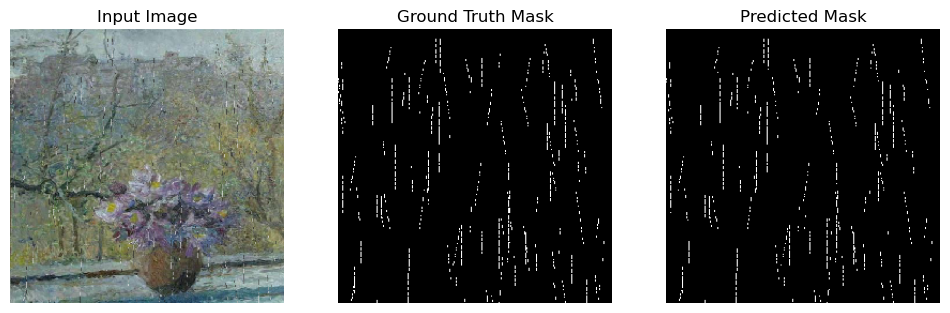

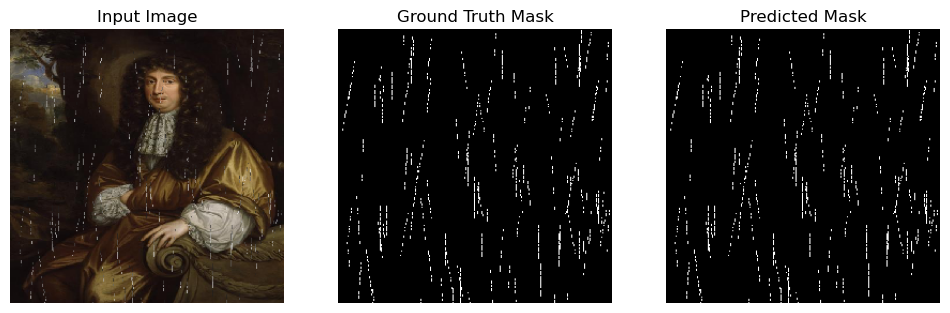

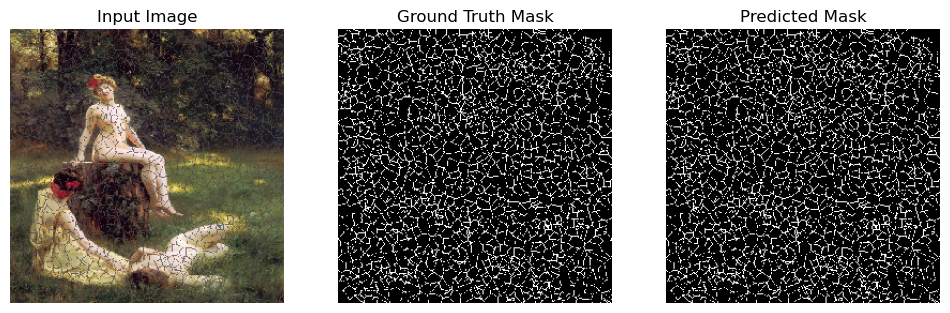

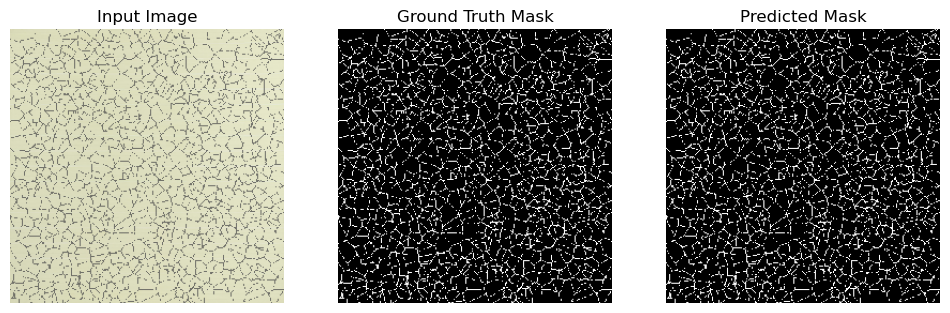

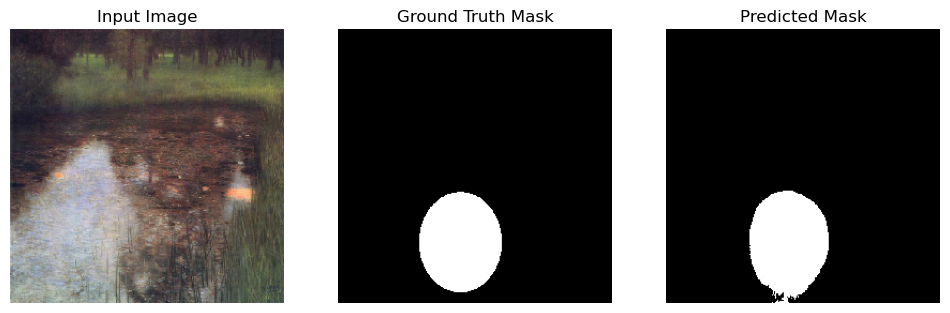

In [21]:
# --- Visualize ---
def visualize_predictions(model, generator, num_samples=5):
    import matplotlib.pyplot as plt
    import random

    indices = random.sample(range(len(generator.image_filenames)), num_samples)
    for idx in indices:
        img_path = os.path.join(generator.image_dir, generator.image_filenames[idx])
        mask_path = os.path.join(generator.mask_dir, generator.image_filenames[idx].replace(".png", "-mask.png"))

        img = load_img(img_path, target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")
        mask_array = img_to_array(mask) / 255.0

        pred = model.predict(np.expand_dims(img_array, axis=0))[0, :, :, 0]
        pred_binary = (pred > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img_array)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask_array[:, :, 0], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_binary, cmap="gray")
        plt.axis("off")

        plt.show()


visualize_predictions(model, test_generator)

### Inference of unet_damage_mappingv2

In [28]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def map_damage(img_path, model):
    # Load original size for display
    with Image.open(img_path) as img_pil:
        width, height = img_pil.size

    # Preprocess image
    img = load_img(img_path, target_size=(256, 256))
    img_array = img_to_array(img) / 255.0

    # Predict damage mask
    pred = model.predict(np.expand_dims(img_array, axis=0))[0, :, :, 0]
    pred_binary = (pred > 0.5).astype(np.uint8)

    print("Prediction min/max:", pred.min(), pred.max())
    
    # Display original + prediction
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(img_array)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Predicted Damages")
    plt.imshow(pred_binary, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Prediction min/max: 2.6600389e-10 0.45098206


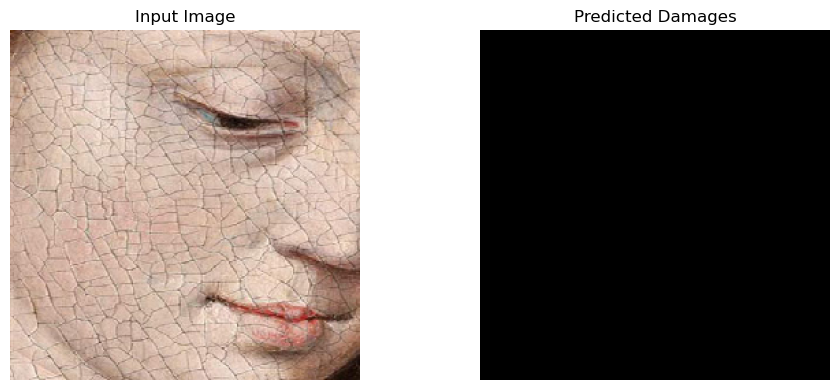

In [29]:
map_damage("cracked-portrait.jpg", model)

Prediction min/max: 3.2866267e-14 0.8252691


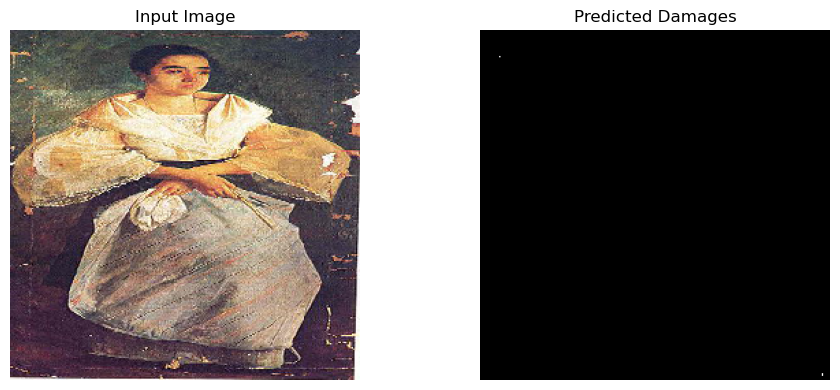

In [30]:
map_damage('278px-La_Bulaquena_by_Juan_Luna.jpg', model)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

def debug_prediction_inspection(img_path, model, threshold=0.5, image_size=(256, 256)):
    # Load and preprocess image
    original_img = Image.open(img_path)
    width, height = original_img.size

    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0

    # Run model prediction
    pred = model.predict(np.expand_dims(img_array, axis=0))[0, :, :, 0]

    # Threshold binary prediction
    pred_binary = (pred > threshold).astype(np.uint8)

    # Log prediction stats
    print(f"Prediction stats: min={pred.min():.4f}, max={pred.max():.4f}, mean={pred.mean():.4f}")
    print(f"Non-zero pixels (pred > {threshold}):", np.count_nonzero(pred_binary))

    # Visualize results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(img_array)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Prediction Heatmap")
    plt.imshow(pred, cmap="hot")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Thresholded Mask (>{threshold})")
    plt.imshow(pred_binary, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Prediction stats: min=0.0000, max=0.4510, mean=0.0039
Non-zero pixels (pred > 0.5): 0


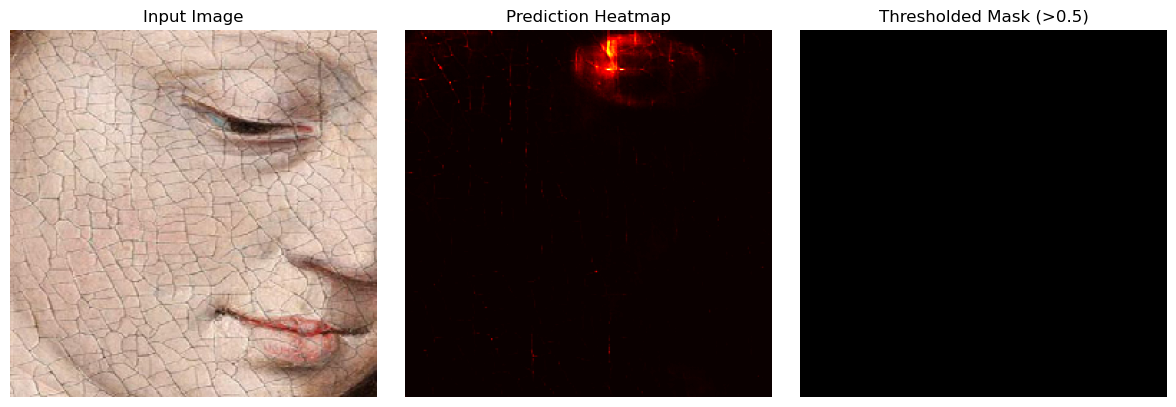

In [32]:
debug_prediction_inspection("cracked-portrait.jpg", model)

### Visualize Results of Initial Run
from `unet_damage_mapping.h5`

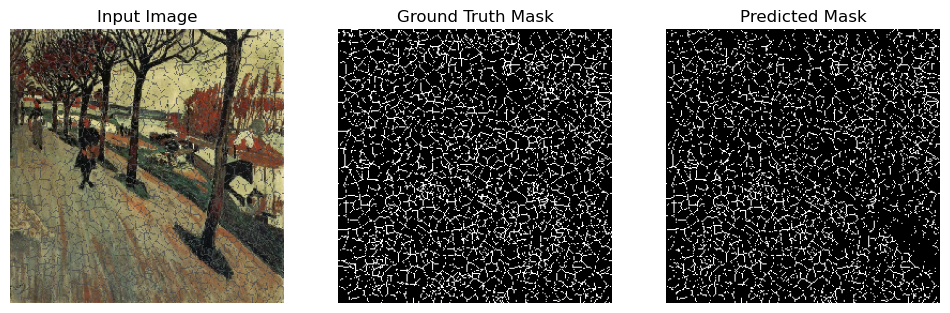

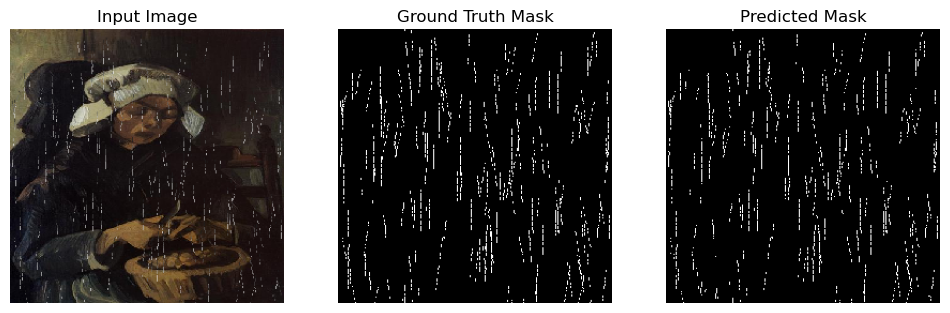

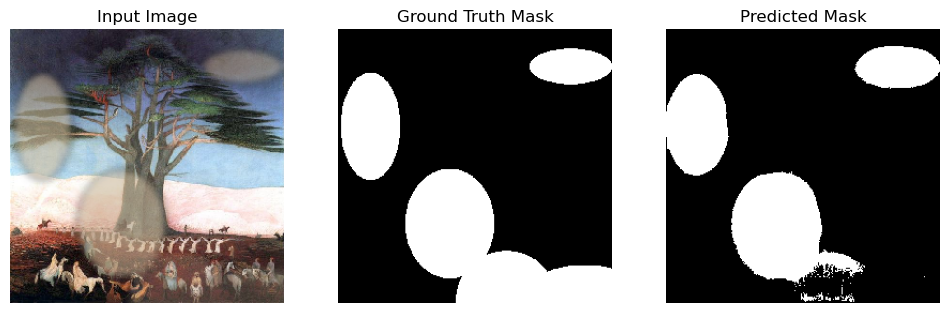

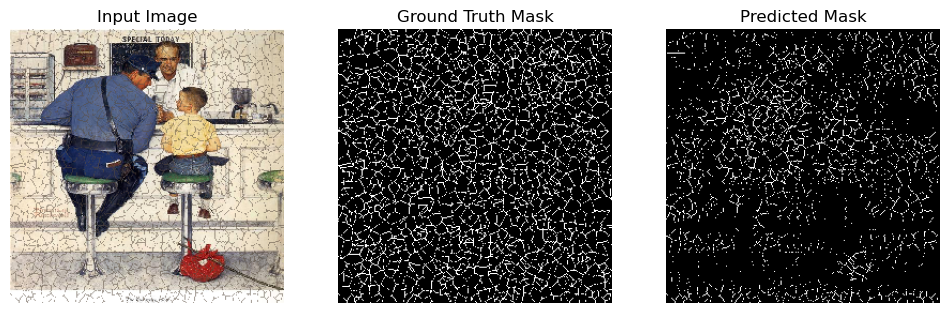

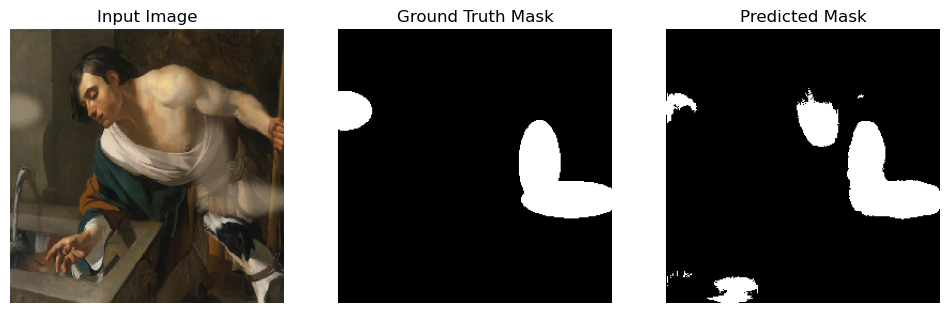

In [14]:
# --- Visualize ---
def visualize_predictions(model, generator, num_samples=5):
    import matplotlib.pyplot as plt
    import random

    indices = random.sample(range(len(generator.image_filenames)), num_samples)
    for idx in indices:
        img_path = os.path.join(generator.image_dir, generator.image_filenames[idx])
        mask_path = os.path.join(generator.mask_dir, generator.image_filenames[idx].replace(".png", "-mask.png"))

        img = load_img(img_path, target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")
        mask_array = img_to_array(mask) / 255.0

        pred = model.predict(np.expand_dims(img_array, axis=0))[0, :, :, 0]
        pred_binary = (pred > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img_array)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask_array[:, :, 0], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_binary, cmap="gray")
        plt.axis("off")

        plt.show()


visualize_predictions(model, test_generator)